/home/gstmchen/miniconda3/envs/d1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


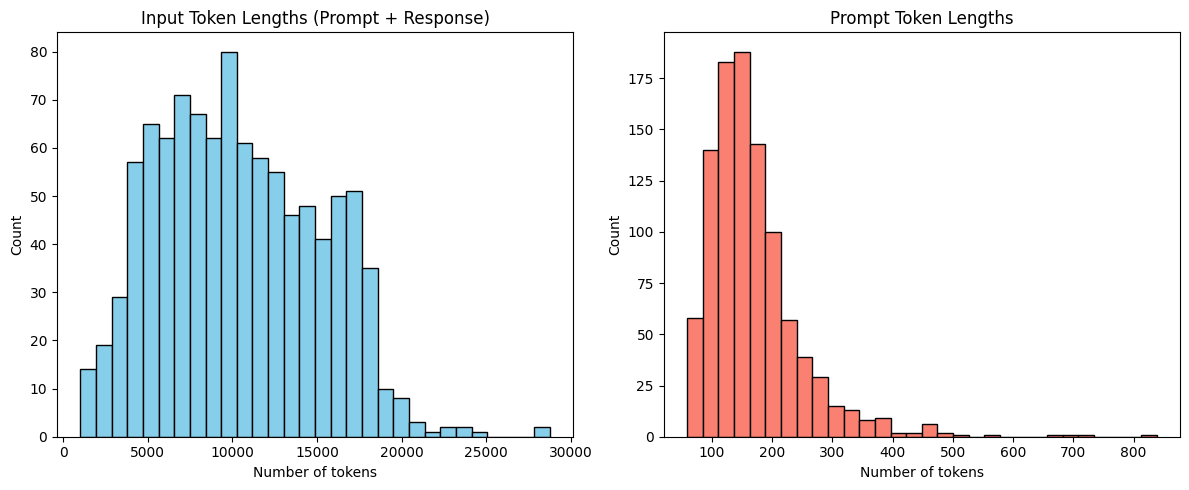

In [1]:
from transformers import AutoTokenizer
from datasets import load_dataset

import matplotlib.pyplot as plt

# Use the same model as in sft_train.py
model_name = "GSAI-ML/LLaDA-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="right", trust_remote_code=True, use_fast=True)

# Load the s1.1K dataset
dataset = load_dataset("simplescaling/s1K-1.1", split="train")

# SYSTEM_PROMPT as in sft_trainer.py
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
Your reasoning here
</reasoning>
<answer>
...
</answer>
"""

input_token_lengths = []
prompt_token_lengths = []
n = len(dataset)

for i in range(n):
    question = SYSTEM_PROMPT + "\n\n" + dataset[i]["question"]
    trajectory = f"<reasoning>{dataset[i]['deepseek_thinking_trajectory']}</reasoning>\n<answer>{dataset[i]['deepseek_attempt']}</answer>"
    prompt = [{"role": "user", "content": question}]
    response = [{"role": "assistant", "content": trajectory}]
    # Full input (prompt + response)
    full_input = tokenizer.apply_chat_template(prompt + response, tokenize=False)
    # Prompt only
    prompt_only = tokenizer.apply_chat_template(prompt, tokenize=False) + "\n"
    # Tokenize
    input_ids = tokenizer(full_input, return_tensors="pt").input_ids
    prompt_ids = tokenizer(prompt_only, return_tensors="pt").input_ids
    input_token_lengths.append(input_ids.shape[1])
    prompt_token_lengths.append(prompt_ids.shape[1])

# Plot the length distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(input_token_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Input Token Lengths (Prompt + Response)")
plt.xlabel("Number of tokens")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(prompt_token_lengths, bins=30, color='salmon', edgecolor='black')
plt.title("Prompt Token Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [1]:
from datasets import load_dataset

# Load the s1.1K dataset
dataset = load_dataset("simplescaling/s1K-1.1", split="train")

/home/gstmchen/miniconda3/envs/d1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Count how many deepseek_thinking_trajectory fields contain "**Final Answer**" (case-insensitive)
final_answer_count = 0
for sample in dataset:
    reasoning = sample.get("deepseek_thinking_trajectory", "")
    if r"\boxed" in reasoning.lower():
        final_answer_count += 1
    else:
        print(reasoning)
        break
print(f"Number of samples with '**Final Answer**' in deepseek_thinking_trajectory: {final_answer_count}")


Okay, let me try to work through these problems one by one. They all seem related to sparse sets, oracles, and these P_angel classes. Let's start with the first one.

**Problem 1:** Given k sparse sets S_1, S_2, ..., S_k, we need to construct a single sparse set S and a poly-time TM M with oracle access to S such that M can decide whether x is in S_i given <x,i> as input.

Hmm. Each S_i is sparse, so for each length n, each S_i has at most p(n) strings of length n. Since there are k sparse sets, maybe we combine them into S in some way. The challenge is to encode all the S_i's into S so that, given x and i, we can query S to check if x is in S_i. Also, S itself must be sparse.

How do we combine multiple sparse sets into one and keep the combined set sparse? Let's think. Suppose each S_i has at most p(n) strings per length n. If k is a constant, then the total number for each n would be k*p(n). If S is the union of all S_i's, but tagged with their index i. Wait, but the union might not

In [ ]:
# Use longllada to process s1K dataset and plot the attention map.

# Assumptions:
# - The LongLLaDA/llada/llada_wrapper.py is in the Python path or can be imported.
# - The model weights and tokenizer are available at the specified path.
# - The s1K dataset is already loaded as `dataset`.
# - The SYSTEM_PROMPT variable is defined.
# - The code is running in a notebook with matplotlib available.

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

# Import the LLaDACausalLM wrapper
from LongLLaDA.llada.llada_wrapper import LLaDACausalLM

# Set up the model path and any required configs
llada_model_path = "GSAI-ML/LLaDA-8B-Instruct"  # or your checkpoint path
llada_kwargs = dict(
    model_kwargs=dict(torch_dtype="auto"),
    max_seq_len=30000,
    model_type=None,  # or 'llama', 'dream', etc. as appropriate
    seed=42,
)

# Initialize the model
llada = LLaDACausalLM(path=llada_model_path, **llada_kwargs)

# Load the s1.1K dataset
dataset = load_dataset("simplescaling/s1K-1.1", split="train")


/home/gstmchen/miniconda3/envs/d1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'steps': 128, 'block_length': 32, 'temperature': 0.0, 'cfg_scale': 0.0, 'remasking': 'low_confidence'}


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Loading checkpoint shards: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


In [8]:

# SYSTEM_PROMPT as in sft_trainer.py
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
Your reasoning here
</reasoning>
<answer>
...
</answer>
"""

# Select a sample from the dataset to process
sample_idx = 0
question = SYSTEM_PROMPT + "\n\n" + dataset[sample_idx]["question"]
prompt = [{"role": "user", "content": question}]
full_input = llada.tokenizer.apply_chat_template(prompt, tokenize=False)

# Tokenize input
inputs = [full_input]
input_ids = llada.tokenizer(inputs, return_tensors="pt", padding=True, truncation=True, max_length=llada.max_seq_len).input_ids.to(llada.model.device)

# LLaDA does not support output_attentions=True and will raise an error if you try.
# Instead, we can only generate output, and cannot extract attention maps directly.
# We'll generate the model's output and print it.

with torch.no_grad():
    output = llada.model.generate(
        input_ids=input_ids,
        max_new_tokens=256,
        do_sample=False,
        return_dict_in_generate=False,
        output_scores=False,
        past_key_values=None,
        use_cache=False,
    )

# Decode and print the generated output
generated_ids = output[0][input_ids.shape[1]:]  # skip prompt tokens
generated_text = llada.tokenizer.decode(generated_ids, skip_special_tokens=True)
print("Generated output:")
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:126081 for open-end generation.


Generated output:





In [9]:
output

tensor([[126080, 126346,   3840, 126347,    198,    198,  71808,    296,    268,
           2538,   6149,     25,    198,     27,  23847,    283,     29,    198,
           6943,  25306,   1655,    198,   1263,  23847,    283,     29,    198,
             27,  31113,     29,    198,   1152,    198,   1263,  31113,     29,
            198,    198,    198,  19781,    259,  17489,   1788,     11,   4223,
            403,    409,    259,  15004,    296,  15506,   3935,    301,  13125,
            268,   1963,    300,    268,  10559,  72974,    301,  24080,     13,
           1741,   1099,   1494,  17489,   5803,   1745,    220,     15,    301,
            220,     16,    627,    558,     17,     15,   1906,   7670,     92,
          99968,    367,    268,  10559,   1963,     30, 126348, 126346,    598,
          10450, 126347,    198,    198,    198,    198, 126081]],
       device='cuda:0')

In [ ]:
# Test accuracy on s1K dataset
from test_s1_accuracy import load_model_and_tokenizer, evaluate_dataset

# Load model and tokenizer (using default Qwen2.5-7B-Instruct)
model, tokenizer = load_model_and_tokenizer("Qwen/Qwen2.5-7B-Instruct")

# Test on a subset of the dataset (first 10 samples for quick testing)
print("Testing accuracy on s1K dataset...")
results, accuracy, correct_count, total_samples = evaluate_dataset(
    model=model, 
    tokenizer=tokenizer, 
    dataset=dataset, 
    max_samples=10
)

print(f"\nFinal Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
